In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1' # select GPU if needed
import math
import numpy as np
np.seterr(all = 'ignore')
import torch
import torch.nn as nn
torch.manual_seed(0) # initial seed for random number generator

import time
datetime = time.strftime('%Y%m%d_%H%M')
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat

from PRModule import *

input data size = (512, 512)
psd: 100%|██████████| 256/256 [00:01<00:00, 226.23it/s]


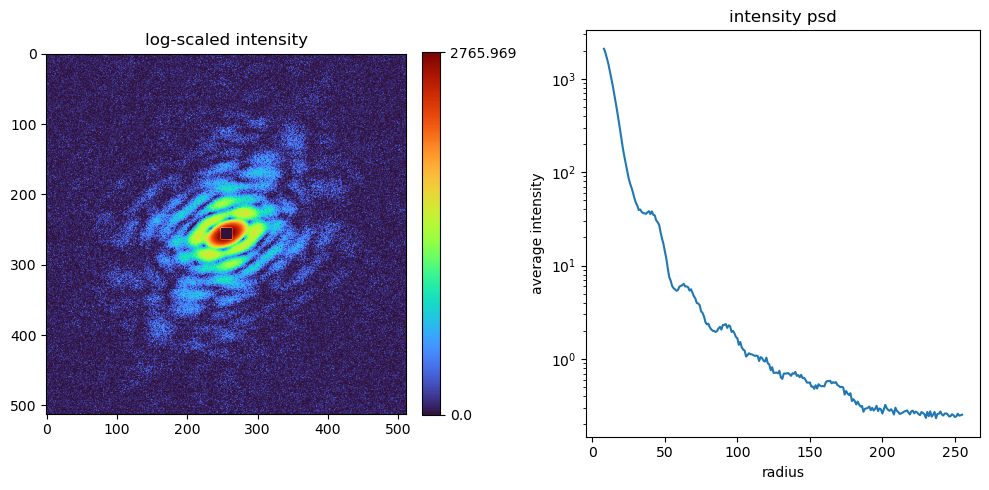

In [2]:
'''
read .mat file and plot input intensity

input data should be intensity
for dpGPS, intensity has to be normalized by photon count
missing data should be masked with NaN
'''

# load input data
cnt_ph = '1e6'
save_name = 'lenna_{}'.format(cnt_ph) # name for saving result
save_path = '.' # path for saving result
path = './sample_lenna.mat'
f_in = loadmat(path)

intensity = np.power(f_in['amp_' + cnt_ph], 2)
# generate missing center
missing = np.zeros_like(intensity)
missing[256 - 8:256 + 8, 256 - 8:256 + 8] = 1
missing = missing > 0
intensity[missing] = 0
# get ground true image
sample = np.zeros_like(intensity)
sample[256 - 16:256 + 16, 256 - 16:256 + 16] = f_in['obj_' + cnt_ph]
# get support
support = np.zeros_like(intensity)
support[256 - 16:256 + 16, 256 - 16:256 + 16] = f_in['supp']
    
sample = sample * support
sample[sample < 0] = 0

print('input data size = {}'.format(intensity.shape))
time.sleep(1)

# plot intensity and psd
log_intensity = np.log(intensity + 1)
psd_intensity = PSD(intensity, mask = missing)
plt.figure(figsize = (10, 5), dpi = 100)
plt.subplot(121)
plt.imshow(log_intensity, cmap = 'turbo')
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.set_ticks([np.nanmin(log_intensity), np.nanmax(log_intensity)])
cbar.set_ticklabels([np.nanmin(intensity), np.nanmax(intensity)])
plt.title('log-scaled intensity')
plt.subplot(122)
plt.plot(psd_intensity)
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('average intensity')
plt.title('intensity psd')
plt.tight_layout()
plt.show()

In [3]:
# cast data type to single
input = np.sqrt(np.fft.ifftshift(intensity)).astype(np.single) # ifftshifted
unknown = np.fft.ifftshift(missing).astype(np.single)
support = support.astype(np.single)
# convet to torch tensor
h = input.shape[0]
w = input.shape[1]
input = torch.from_numpy(input).view(1, 1, h, w, 1)
unknown = torch.from_numpy(unknown).view(1, 1, h, w, 1)
support = torch.from_numpy(support).view(1, 1, h, w, 1)

In [4]:
# phase retrieval arguments
n_seed = 500 # number of seeds
n_batch = 100 # size of batch, number of seeds in one epoch
n_iter = 3000 # number of phase retrieval iterations

info = {
    'algorithm' : 'GPS-F', # [HIO, RAAR, gRAAR, dRAAR, GPS-R, GPS-F, dpGPS-R, dpGPS-F]
    'error' : 'R', # [R, NLL]
    'shrinkwrap' : False, # [True, False]

    # parameters of HIO, RAAR, gRAAR, dRAAR
    'beta' : 0.5, # projection coefficient
    'beta_type' : 'linear', # ['const', 'linear', 'step'] for beta control (step from RAAR paper)
    'beta_lim' : 1, # final beta
    'boundary_push' : 0, # final boundary push stage ratio in total iteration
    # common parameters of GPS, dpGPS
    'sigma' : (0, 0.01, 0.4, 0.1, 0.7, 1), # parameter for relaxing magnitude constraint
    'alpha_count' : 10, # number of finer frequency filter for relaxing support constraint
    # parameters of GPS
    't' : 1, # parameter of proximal operator on magnitude constraint
    's' : 0.8, # parameter of proximal operator on support constraint
    # preconditioner setting for dRAAR, dpGPS
    'limit' : 0.2, # preconditioner value range [1-limit, 1+limit]
    'deep' : True, # whether to select deep learning-based preconditioner or not

    # shrinkwrap setting
    'sigma_initial' : 3, # initial sigma
    'sigma_limit' : 1.5, # lower boundary of sigma
    'ratio_update' : 0.01, # sigma update ratio
    'threshold' : 0.1, # threshold for defining new support
    'interval' : 50, # shrinkwrap interval
}

In [5]:
# initialize phase retrieval iterator
iterator = PhaseRetrieval(input, support, unknown, **info)
# select computing device
isCUDA = True
if isCUDA:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        if torch.cuda.device_count() > 1:
            iterator = nn.DataParallel(iterator)
    else:
        raise Exception('CUDA is not available.')
else:
    device = torch.device('cpu')
# allocate iterator
iterator = iterator.to(device)

In [6]:
# select output type
otype = 'u' # [u, z]
output = torch.zeros(n_seed, 1, h, w, 1 if otype == 'u' else 2)
path = torch.zeros(n_seed, n_iter)
n_max = math.ceil(n_seed / n_batch)
t_elap = time.time()
for n in tqdm(range(n_max)):
    # make initial random phase
    n_batch_cur = n_batch
    if n == n_max - 1 and n_seed % n_batch > 0:
        n_batch_cur = n_seed % n_batch
    phi = torch.rand(n_batch_cur, 1, h, w, 1) * 2 * math.pi
    phi = torch.cat((torch.cos(phi), torch.sin(phi)), dim = -1)
    phi = phi.to(device)
    # perform phase retrieval iteration
    output[n * n_batch:min((n + 1) * n_batch, n_seed), :, :, :, :], \
        path[n * n_batch:min((n + 1) * n_batch, n_seed), :] \
            = iterator(n_iter, phi, toggle = otype == 'z', **info)
t_elap = time.time() - t_elap

100%|██████████| 5/5 [04:45<00:00, 57.07s/it]


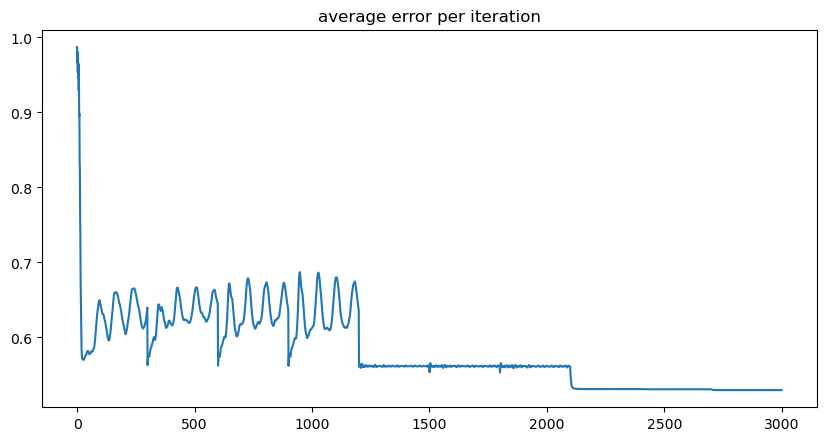

In [7]:
plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(path.mean(dim = 0))
plt.title('average error per iteration')
plt.show()

In [8]:
# conver results to numpy ndarray
output = output.squeeze().numpy()
path = path.numpy()
# sort by minimum error
error = np.amin(path, axis = 1)
order = np.argsort(error)
output = output[order, :, :]
path = path[order, :]
error = error[order]
# subpixel alignment
output = SubpixelAlignment(output, ref = sample, subpixel = 10)

subpixel alignment: 100%|██████████| 500/500 [00:34<00:00, 14.63it/s]


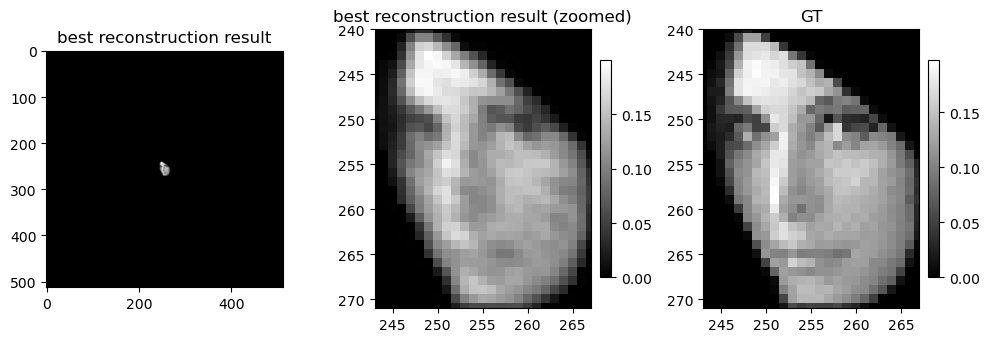

In [9]:
# plot best reconstruction result
plt.figure(figsize = (10, 5), dpi = 100)
plt.subplot(131)
plt.imshow(output[0], cmap = 'gray')
plt.title('best reconstruction result')
plt.subplot(132)
plt.imshow(output[0], cmap = 'gray')
ib, jb = np.nonzero(sample > 0)
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('best reconstruction result (zoomed)')
plt.subplot(133)
plt.imshow(sample, cmap = 'gray')
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('GT')
plt.tight_layout()
plt.show()

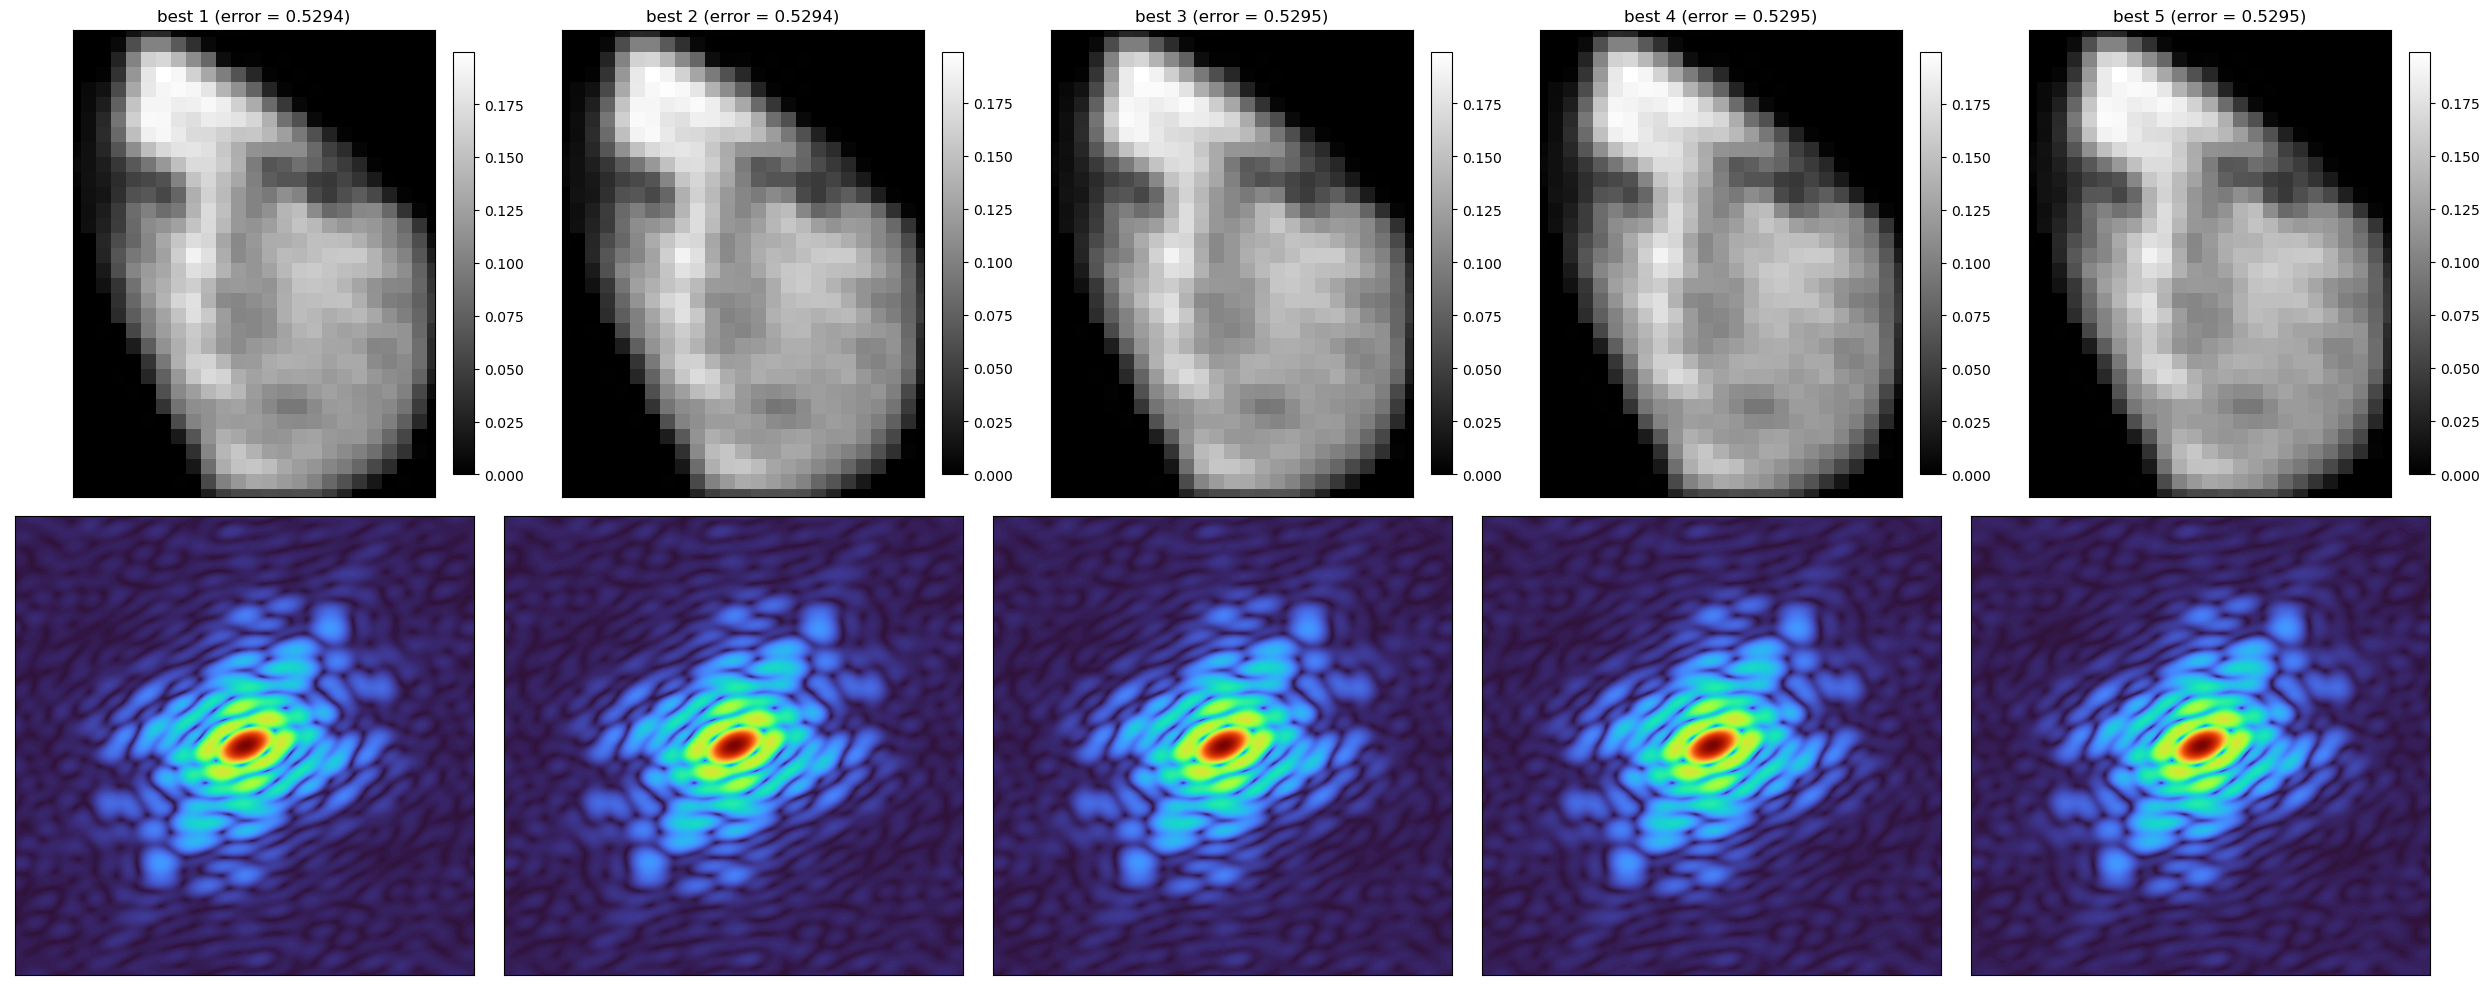

In [10]:
# plot best 5
plt.figure(figsize = (25, 10), dpi = 100)
# plot r-space
plt.subplot(2, 5, 1)
plt.imshow(output[0], cmap = 'gray')
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('best 1 (error = {:.4f})'.format(error[0]))
plt.subplot(2, 5, 2)
plt.imshow(output[1], cmap = 'gray')
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('best 2 (error = {:.4f})'.format(error[1]))
plt.subplot(2, 5, 3)
plt.imshow(output[2], cmap = 'gray')
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('best 3 (error = {:.4f})'.format(error[2]))
plt.subplot(2, 5, 4)
plt.imshow(output[3], cmap = 'gray')
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('best 4 (error = {:.4f})'.format(error[3]))
plt.subplot(2, 5, 5)
plt.imshow(output[4], cmap = 'gray')
plt.xlim(np.amin(jb), np.amax(jb))
plt.ylim(np.amax(ib), np.amin(ib))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('best 5 (error = {:.4f})'.format(error[4]))
# plot k-space
plt.subplot(2, 5, 6)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(output[0]))) + 1), cmap = 'turbo')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 5, 7)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(output[1]))) + 1), cmap = 'turbo')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 5, 8)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(output[2]))) + 1), cmap = 'turbo')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 5, 9)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(output[3]))) + 1), cmap = 'turbo')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 5, 10)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(output[4]))) + 1), cmap = 'turbo')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [11]:
# calculate pairwise distance in r-space
dpair = PairwiseDistance(output)
# calculate PRTF and its PSD
prtf = PRTF(output, ref = np.sqrt(intensity), mask = missing)
prtf_psd = PSD(prtf, mask = missing)

psd: 100%|██████████| 256/256 [00:01<00:00, 232.57it/s]


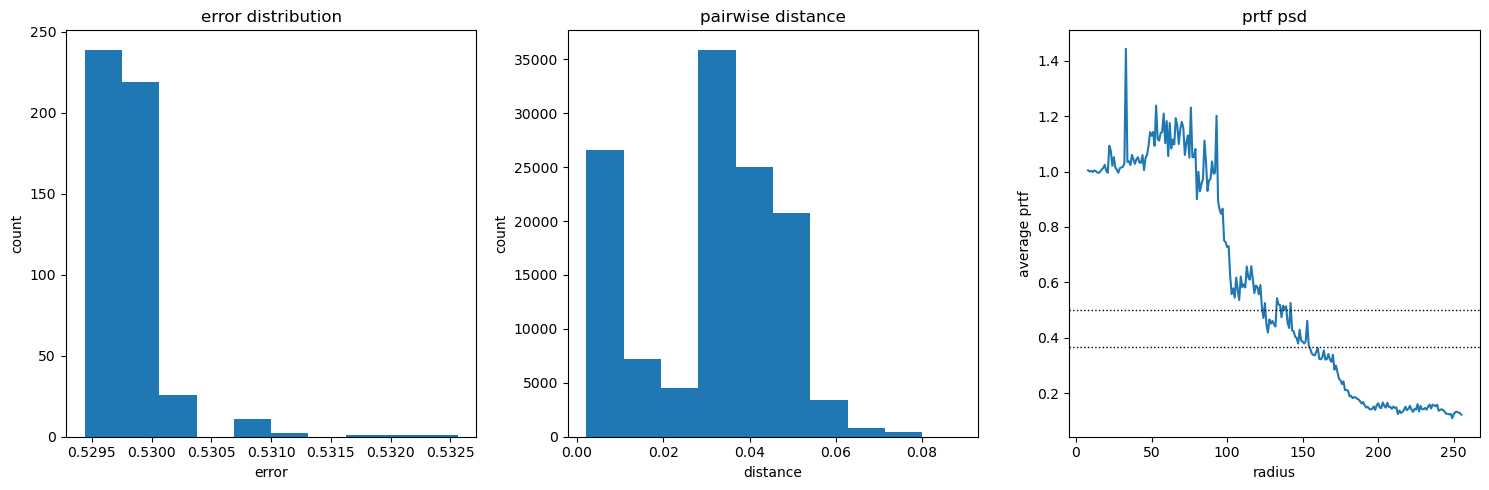

In [12]:
# plot metric
plt.figure(figsize = (15, 5), dpi = 100)
plt.subplot(131)
plt.hist(error)
plt.xlabel('error')
plt.ylabel('count')
plt.title('error distribution')
plt.subplot(132)
plt.hist(dpair)
plt.xlabel('distance')
plt.ylabel('count')
plt.title('pairwise distance')
plt.subplot(133)
plt.plot(prtf_psd)
plt.axhline(0.5, color = 'k', linestyle = ':', linewidth = 1)
plt.axhline(0.36788, color = 'k', linestyle = ':', linewidth = 1)
plt.xlabel('radius')
plt.ylabel('average prtf')
plt.title('prtf psd')
plt.tight_layout()
plt.show()

In [13]:
# comparison with GT
# from skimage.metrics import hausdorff_distance as HAUS
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
def L1Dist(template, target):
    return np.sum(np.abs(target - template)) / np.sum(template)

def errF(i, obj):
    eps = 1e-08
    
    i = i * (1 - missing)
    a = np.sqrt(i)
    
    aa = np.abs(np.fft.fftshift(np.fft.fft2(obj))) * (1 - missing)
    ii = np.power(aa, 2)
    
    R = np.abs(aa - a).sum() / a.sum()

    NLL = ii - i * np.log(ii + eps) + i * np.log(i + eps) - i + 0.5 * np.log(2 * math.pi * i + eps)
    valid = (1 - missing) * (i > 1)
    NLL = NLL * valid
    NLL = np.sum(NLL) / np.sum(valid)
    
    return R, NLL

gt = sample[256 - 16:256 + 16, 256 - 16:256 + 16].astype(np.single)
obj = output[:, 256 - 16:256 + 16, 256 - 16:256 + 16]
d_dist = np.zeros(n_seed)
# d_haus = np.zeros(n_seed)
d_ssim = np.zeros(n_seed)
d_psnr = np.zeros(n_seed)
d_R = np.zeros(n_seed)
d_NLL = np.zeros(n_seed)

for i, tmp in tqdm(enumerate(obj), total = n_seed):
    d_dist[i] = L1Dist(gt, tmp)
#     d_haus[i] = HAUS(gt, tmp)
    d_ssim[i] = SSIM(gt, tmp)
    d_psnr[i] = PSNR(gt, tmp)
    d_R[i], d_NLL[i] = errF(intensity, output[i])
    
#     try:
#         d_psnr[i] = PSNR(gt, tmp)
#     except:
#         d_psnr[i] = PSNR(gt, tmp, data_range = tmp.max() - min(gt.min(), tmp.min()))

100%|██████████| 500/500 [00:21<00:00, 23.01it/s]


In [14]:
# save result
isSave = False
if isSave:
    savemat('{}/{}_{}.mat'.format(save_path, save_name, datetime), {
        'result' : output, 'error' : error, 'info' : info, 't_elap' : t_elap,
    'dpair' : dpair, 'prtf' : prtf, 'prtf_psd': prtf_psd,
    'dist' : d_dist, 'ssim' : d_ssim, 'psnr' : d_psnr,
    'r-factor' : d_R, 'nll' : d_NLL})